## Configuración Inicial

In [ ]:
# ========================================
# IMPORTS
# ========================================
"""
Importación de librerías necesarias para procesamiento de lenguaje natural, 
visualización, entrenamiento de modelos de clasificación clásicos y embeddings contextuales.
Incluye compatibilidad con spaCy, BERT (BETO), NLPaug, y LLaMA vía Ollama.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Librerías Generales
import re
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import os
import joblib

# Librerías de Manejo de Datos y Visualización
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías de Procesamiento de Lenguaje Natural
import nltk
import emoji
import spacy
from wordsegment import load, segment
import nlpaug.augmenter.word as naw
from nltk.corpus import wordnet as wn

# Librerías de Machine Learning
import tensorflow as tf
import torch
import torch.nn.functional as F
from transformers import TFBertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import issparse

# Ollama
from ollama import Client

In [26]:
# ========================================
# CONFIGURACION Y CARGA DE DATOS
# ========================================
"""
Carga del dataset, configuración de semilla aleatoria y preparación inicial del entorno NLP.
Incluye inicialización de etiquetado binario (LabelEncoder) y carga de modelos spaCy y WordSegment.
Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

random_state = 1
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')
nlp = spacy.load("es_core_news_sm")
load()

df = pd.read_csv("data.csv")
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['control', 'anorexia']) 
df['label_enc'] = label_encoder.transform(df['class'])
df.info()
df.describe()
df.head(5)

df = df.sample(frac=0.05, random_state=random_state).reset_index(drop=True)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     1500 non-null   object
 1   tweet_id    1500 non-null   object
 2   tweet_text  1500 non-null   object
 3   class       1500 non-null   object
 4   label_enc   1500 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 58.7+ KB


## Preprocesamientos
- Preprocesamiento BETO
- Preprocesamiento BoW
- Aumentador de datos

In [27]:
# ========================================
# PREPROCESAMIENTO BETO
# ========================================
"""
Transformación de textos usando embeddings contextuales de BETO (BERT entrenado en español).
Se aplican: demojización, tokenización, extracción del vector CLS y reducción dimensional con SVD.

Autor(es):
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def convert_emojis(text):
    '''
    Convierte emojis a texto usando la librería emoji.
    Se creó una función para evitar problemas al realizar las pruebas unitarias.
    '''
    return emoji.demojize(text)

def preprocess_text_bert(text):
    '''
    Preprocesamiento de texto para BETO:
    - Demojización
    - Tokenización
    - Extracción del vector CLS
    - Reducción dimensional con SVD
    '''
    text = convert_emojis(text)
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors='tf')
    model_output = model(encoded_input)
    embeddings = model_output.last_hidden_state[:, 0, :].numpy()
    return embeddings.flatten()

print("Procesando embeddings BETO...")
df['tweet_text_beto'] = df['tweet_text'].apply(preprocess_text_bert)
embeddings_matrix = np.stack(df['tweet_text_beto'].values)
embeddings_scaled = StandardScaler().fit_transform(embeddings_matrix)
svd = TruncatedSVD(n_components=500, random_state=random_state)
X_beto = svd.fit_transform(embeddings_scaled)
print("Embeddings BETO procesados.")

Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Procesando embeddings BETO...
Embeddings BETO procesados.


In [28]:
# ========================================
# PREPROCESAMIENTO BAG OF WORDS (BoW)
# ========================================
"""
Pipeline clásico de procesamiento de texto: limpieza, lematización, segmentación de hashtags,
y extracción de características con Bag of Words (CountVectorizer con n-gramas).
Incluye cálculo de una métrica adicional: ratio de palabras en mayúsculas.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""


def split_hashtag(tag, verbose=False):
    '''
    Divide un hashtag en palabras separadas utilizando varias técnicas de segmentación.
    Esta función procesa hashtags y los convierte en frases legibles utilizando 
    dos métodos principales: detección de CamelCase y segmentación de palabras.
    - Primero elimina el símbolo '#' si existe
    - Intenta dividir por patrones CamelCase (mayúscula después de minúscula)
    - Si no hay patrones CamelCase, utiliza la biblioteca wordsegment para 
      identificar palabras dentro del texto concatenado
    - En caso de error durante la segmentación, devuelve el hashtag original en minúsculas
    '''
    tag = tag.lstrip('#')
    camel_split = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', tag).lower()
    if camel_split == tag.lower():
        try:
            segmented = segment(tag.lower())
            result = " ".join(segmented) if segmented else tag.lower()
            if verbose:
                print(f"Hashtag segmentado: #{tag} → {result}")
            return result
        except:
            if verbose:
                print(f"Error al segmentar hashtag: #{tag}. Se mantiene en minúsculas.")
            return tag.lower()
    if verbose:
        print(f"Hashtag segmentado por CamelCase: #{tag} → {camel_split}")
    return camel_split


def preprocess_text_bow(text, verbose=False):
    '''
    Esta función realiza múltiples operaciones de limpieza y normalización en un texto
    para prepararlo para análisis de lenguaje natural. El procesamiento incluye:
    conversión de emojis a texto, segmentación de hashtags, eliminación de URLs, 
    menciones, números, palabras vacías, y lematización de palabras.

    - Convierte emojis a texto descriptivo usando la función 'convert_emojis'
    - Divide hashtags en palabras separadas usando 'split_hashtag'
    - Elimina URLs, menciones (@usuario), y números
    - Elimina palabras vacías (stop words) y signos de puntuación
    - Lematiza las palabras restantes
    - Utiliza el pipeline de spaCy (objeto 'nlp') para procesamiento de lenguaje
    '''
    text = convert_emojis(text).lower()
    hashtags = re.findall(r"#\w+", text)
    for tag in hashtags:
        text = text.replace(tag, split_hashtag(tag, verbose=verbose))
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"\d+", "", text)
    doc = nlp(text)
    lemmatized_words = [
        token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num
    ]
    cleaned = " ".join(lemmatized_words)
    if verbose:
        print(f"Texto lematizado: {cleaned[:50]}...")
    return cleaned


def calculate_uppercase_ratio(text, verbose=False):
    '''
    Calcula la proporción de palabras en mayúsculas en un texto dado.
    - Divide el texto en palabras usando el método split()
    - Filtra las palabras que están completamente en mayúsculas
    - Devuelve la proporción de palabras en mayúsculas respecto al total de palabras
    - Si no hay palabras, devuelve 0.0
    '''
    words = text.split()
    if not words:
        if verbose:
            print("Texto vacío, ratio de mayúsculas: 0.0")
        return 0.0
    uppercase_words = [w for w in words if w.isupper()]
    ratio = len(uppercase_words) / len(words)
    if verbose:
        print(f"Ratio de mayúsculas calculado: {ratio:.2f}")
    return ratio

print("Procesando texto para Bag of Words...")
# Aplicar preprocesamiento a los textos
df['uppercase_ratio'] = df['tweet_text'].apply(calculate_uppercase_ratio)
features = df['tweet_text'].apply(preprocess_text_bow)
df['cleaned_tweet'] = features

# Bag of Words con CountVectorizer, incluyendo unigramas y bigramas.
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_bow = vectorizer.fit_transform(df['cleaned_tweet'])

y = df['label_enc'].values

print("Preprocesamiento de Bag of Words completado.")

Procesando texto para Bag of Words...
Preprocesamiento de Bag of Words completado.


In [ ]:
# ========================================
# AUGMENTADOR 
# ========================================
"""
Aplicación de técnicas de aumentación textual para la rama BoW.
Se pueden aplicar sustituciones contextuales con BERT o técnicas clásicas como sinónimos (WordNet) e intercambio de palabras.
El usuario puede activar aumentación con AUGMENT_DATA = True y guardar el nuevo dataset extendido.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""

import nltk
from nltk.corpus import wordnet as wn
nltk.download('omw-1.4')
nltk.download('wordnet')

AUGMENT_DATA = False
augmenter = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-uncased',
    model_type='bert',
    action="substitute",
    device='cpu'
)

def generate_augmented_bow_data(X_texts, y_labels, augment_factor=1):
    '''
    Genera datos aumentados para el modelo BoW utilizando un factor de aumentación.
    - X_texts: lista de textos originales
    - y_labels: lista de etiquetas originales
    - augment_factor: número de veces que se desea aumentar cada texto
    - Devuelve listas de textos y etiquetas aumentadas
    '''

    aug_texts, aug_labels = [], []
    for i, text in enumerate(X_texts):
        for _ in range(augment_factor):
            try:
                aug = augmenter.augment(text)
            except:
                aug = text
            aug_texts.append(aug)
            aug_labels.append(y_labels[i])
    return aug_texts, aug_labels

# Reemplazo de SynonymAug con función personalizada para español
def get_spanish_synonyms(word):
    synonyms = set()
    for synset in wn.synsets(word, lang='spa'):
        for lemma in synset.lemmas('spa'):
            synonym = lemma.name().replace("_", " ")
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

class SpanishSynonymAug:
    def __init__(self, aug_p=0.3):
        self.aug_p = aug_p

    def augment(self, text):
        words = text.split()
        new_words = words.copy()
        num_to_aug = max(1, int(len(words) * self.aug_p))
        indices = list(range(len(words)))
        random.shuffle(indices)

        for idx in indices:
            word = words[idx]
            synonyms = get_spanish_synonyms(word)
            if synonyms:
                new_words[idx] = random.choice(synonyms)
                num_to_aug -= 1
            if num_to_aug <= 0:
                break
        return " ".join(new_words)

# Reemplazo de syn_aug con versión funcional
syn_aug = SpanishSynonymAug(aug_p=0.3)
swap_aug = naw.RandomWordAug(action="swap", aug_p=0.2)

def augment_text_complex(text, num_augments=1):
    '''
    Genera múltiples versiones aumentadas de un texto utilizando sinónimos y permutaciones.
    - text: texto original a aumentar
    - num_augments: número de versiones aumentadas a generar
    - Devuelve una lista de textos aumentados
    '''
    augmented_texts = []
    for _ in range(num_augments):
        aug_type = random.choice(['synonym', 'swap'])
        if aug_type == 'synonym':
            augmented = syn_aug.augment(text)
        elif aug_type == 'swap':
            augmented = swap_aug.augment(text)
        else:
            augmented = text
        if isinstance(augmented, list):
            augmented = augmented[0]
        augmented_texts.append(augmented)
    return augmented_texts

original_texts = list(df['cleaned_tweet'])
original_labels = list(y)

# Si se elige aumentar los datos, se generan versiones aumentadas de los textos originales
if AUGMENT_DATA:
    print("Generando datos aumentados para BoW...")
    augmented_texts = []
    augmented_labels = []

    for text, label in zip(original_texts, original_labels):
        augmented_versions = augment_text_complex(text, num_augments=2)
        augmented_texts.extend(augmented_versions)
        augmented_labels.extend([label] * len(augmented_versions))

    # Dataset extendido: original + aumentados
    combined_texts = list(df['cleaned_tweet']) + augmented_texts
    combined_labels = list(y) + augmented_labels

    # Guardar dataset
    df_aug = pd.DataFrame({
        'tweet_text': combined_texts,
        'label_enc': combined_labels
    })
    df_aug.to_csv("augmented_data.csv", index=False)
    print("Datos aumentados guardados como 'augmented_data.csv'.")

else:
    print("AUGMENT_DATA = False — Usando solo los datos originales.")
    combined_texts = original_texts
    combined_labels = original_labels

vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_aug_bow = vectorizer.fit_transform(combined_texts)
y_aug_bow = np.array(combined_labels)
print("Datos aumentados para BoW procesados.")

AUGMENT_DATA = False — Usando solo los datos originales.
Datos aumentados para BoW procesados.


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Funciones de Clasificación

- Funciones de Evaluación (BETO, BoW)
- Funciones de Evaluación (LLM)
- Definición de hiperparámetros para GridSearch


In [30]:
# ========================================
# FUNCIONES DE EVALUACION CON CV (NLP, NLI)
# ========================================
"""
Define funciones auxiliares para evaluar modelos con validación cruzada:
- Matriz de confusión
- Curva ROC
- Curva de aprendizaje
También guarda los mejores modelos y registra métricas en un diccionario global `results_list`.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

results_list = []

def plot_confusion_matrix_cv(y_true, y_pred, labels, model_name, pipeline_name, ax):
    '''
    Plot de la matriz de confusión utilizando seaborn.
    - y_true: etiquetas verdaderas
    - y_pred: etiquetas predichas
    - labels: etiquetas de clase
    - model_name: nombre del modelo
    - pipeline_name: nombre del pipeline
    - ax: objeto Axes para el plot
    '''
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

def plot_roc_curve_cv(model, X, y, cv, ax):
    '''
    Plot de la curva ROC utilizando validación cruzada.
    - model: modelo entrenado
    - X: características de entrada
    - y: etiquetas de clase
    - cv: número de pliegues para la validación cruzada
    - ax: objeto Axes para el plot
    '''
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        model.fit(X[train_idx], y[train_idx])
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X[test_idx])[:,1]
        else:
            y_score = model.decision_function(X[test_idx])
        y_test_bin = label_binarize(y[test_idx], classes=np.unique(y)).ravel()
        fpr, tpr, _ = roc_curve(y_test_bin, y_score)
        auc = roc_auc_score(y_test_bin, y_score)
        ax.plot(fpr, tpr, label=f"Fold {i+1} (AUC={auc:.2f})")
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.set_title("ROC Curve")
    ax.set_xlabel("Falsos Positivos")
    ax.set_ylabel("Verdaderos Positivos")
    ax.grid(True)
    ax.legend(fontsize='small')

def plot_learning_curve_cv(model, X, y, cv, ax):
    '''
    Plot de la curva de aprendizaje utilizando validación cruzada.
    - model: modelo entrenado
    - X: características de entrada
    - y: etiquetas de clase
    - cv: número de pliegues para la validación cruzada
    - ax: objeto Axes para el plot
    '''
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv, scoring='f1_weighted', n_jobs=-1
    )
    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    val_mean, val_std = np.mean(val_scores, axis=1), np.std(val_scores, axis=1)

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    ax.plot(train_sizes, train_mean, 'o--', color='blue', label='Train Mean')
    ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Val Mean')

    ax.set_title("Learning Curve")
    ax.set_xlabel("Muestras de entrenamiento")
    ax.set_ylabel("F1 Score")
    ax.grid(True)
    ax.legend(fontsize='small')

def evaluate_model_cv(model, param_grid, X, y, model_name, pipeline_name, cv=5, save_dir="saved_models"):
    """
    Realiza búsqueda de hiperparámetros con GridSearchCV y evaluación con CV:
    - Ajusta modelo y predice con cross_val_predict.
    - Guarda el mejor modelo a disco.
    - Muestra métricas, matriz de confusión, ROC y curva de aprendizaje.
    - Almacena resultados en `results_list`.
    """
    print(f"\nEvaluando {model_name} en {pipeline_name} con KFold CV...")

    os.makedirs(save_dir, exist_ok=True)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    grid = GridSearchCV(model, param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    
    # Guardar modelo
    model_filename = f"{save_dir}/{pipeline_name}_{model_name.replace(' ', '_')}.joblib"
    joblib.dump(best_model, model_filename)
    print(f"Modelo guardado como {model_filename}")
    
    y_pred = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1)
    y_prob = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1, method='predict_proba')[:, 1]

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted')
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    auc = roc_auc_score(y, y_prob)

    # Subplots: 1 row x 3 cols
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"{model_name} - {pipeline_name}", fontsize=14)

    plot_confusion_matrix_cv(y, y_pred, labels=np.unique(y), model_name=model_name, pipeline_name=pipeline_name, ax=axs[0])
    if len(np.unique(y)) == 2:
        plot_roc_curve_cv(best_model, X, y, cv, ax=axs[1])
    else:
        axs[1].axis('off')  # ROC not applicable
    plot_learning_curve_cv(best_model, X, y, cv, ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    results_list.append({
        'Pipeline': pipeline_name,
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc,
        'Best Params': grid.best_params_
    })
    

In [ ]:

# ========================================
# FUNCIONES DE EVALUACION CON CV (LLM)
# ========================================
base_prompt = (
    "Eres un modelo de lenguaje entrenado para análisis lingüístico con fines exclusivamente académicos. "
    "Tu función es detectar patrones de texto relacionados con actitudes potencialmente problemáticas hacia la alimentación o la autoimagen, "
    "sin emitir juicios clínicos ni diagnósticos médicos.\n\n"
    "Analiza únicamente el contenido textual de un tweet y responde con una probabilidad entre 0.0 y 1.0 que indique la presencia de lenguaje asociado con:\n"
    "- Restricción alimentaria autoimpuesta\n"
    "- Mención de malestar físico o emocional vinculado con la comida o el cuerpo\n"
    "- Comentarios autocríticos intensos o lenguaje negativo hacia uno mismo\n"
    "- Declaraciones sobre control del peso mediante métodos no recomendados\n"
    "- Enfoque en apariencia corporal extrema o metas de peso estrictas\n"
    "- Uso de expresiones sobre sentirse ‘liviano/a’, ‘vacío/a’ o necesidad de ‘control’\n\n"
    "Este análisis es parte de una investigación orientada a mejorar la comprensión de patrones lingüísticos, y no tiene implicaciones clínicas ni se utilizará para tomar decisiones sobre individuos.\n\n"
    "Tu respuesta debe ser solo un número decimal entre 0.0 y 1.0, donde:\n"
    "- 0.0 indica ausencia total de estos patrones\n"
    "- 1.0 indica presencia fuerte o explícita de múltiples elementos\n\n"
    "Ejemplo de respuesta válida: 0.83\n"
    "No expliques tu razonamiento ni incluyas advertencias. Devuelve únicamente el número decimal."
)

def classify_with_ollama_model_contextual(
    df, model_name, prob_column_name=None, csv_cache_path=None,
    max_workers=4, k_context_reset=5, verbose=False
):
    """
    Clasifica tweets utilizando un modelo LLM disponible vía Ollama, con contexto acumulado por lotes.

    Parámetros:
    - df (pd.DataFrame): DataFrame que debe contener la columna 'tweet_text'.
    - model_name (str): Nombre del modelo LLM registrado en el servidor Ollama.
    - prob_column_name (str, opcional): Nombre de la columna donde se guardarán las probabilidades.
    - csv_cache_path (str, opcional): Ruta para guardar/cargar resultados cacheados.
    - max_workers (int): Número máximo de hilos para procesamiento concurrente.
    - k_context_reset (int): Número de interacciones tras las cuales se reinicia el contexto del sistema.
    - verbose (bool): Si es True, imprime información de depuración durante el procesamiento.

    Retorna:
    - pd.DataFrame: El mismo DataFrame de entrada, con una columna adicional de probabilidades.
    """
    safe_model_id = model_name.replace(':', '_').replace('-', '_')
    if prob_column_name is None:
        prob_column_name = f"{safe_model_id}_prob"
    if csv_cache_path is None:
        csv_cache_path = f"{prob_column_name}_predictions.csv"

    client = Client(host='http://localhost:11434')

    def classify_batch_contextual(batch_texts, start_idx):
        """
        Clasifica un lote de textos usando el modelo LLM con mantenimiento de contexto hasta k_context_reset.

        Parámetros:
        - batch_texts (list[str]): Lista de textos (tweets) a clasificar.
        - start_idx (int): Índice global inicial para trazabilidad y registro.

        Retorna:
        - list[float]: Lista de probabilidades (0.0 a 1.0) o -1.0 si la clasificación falló.
        """
        results = []
        messages = [{"role": "system", "content": base_prompt}]
        context_count = 0

        for i, text in enumerate(batch_texts):
            global_idx = start_idx + i
            messages.append({"role": "user", "content": f"Tweet: '{text}'\nProbabilidad:"})
            try:
                response = client.chat(model=model_name, messages=messages)
                reply = response['message']['content'].strip()
                match = re.search(r"\b([01](?:\.\d+)?)\b", reply)
                prob = float(match.group(1)) if match else -1.0
            except Exception:
                prob = -1.0

            results.append(prob)
            messages.append({"role": "assistant", "content": str(prob)})

            if verbose:
                if prob == -1.0:
                    print(f"[{global_idx}] ❌ Clasificación inválida")
                    print(f"  Tweet   : {text}")
                    print(f"  Respuesta: {reply}")
                else:
                    print(f"[{global_idx}] ✅ Clasificado: {prob}")

            context_count += 1
            if context_count >= k_context_reset:
                if verbose:
                    print(f"[{global_idx}] 🔁 Reinicio de contexto")
                messages = [{"role": "system", "content": base_prompt}]
                context_count = 0
        return results

    def classify_all_multithread(texts):
        """
        Clasifica todos los textos utilizando múltiples hilos y lotes para acelerar el procesamiento.

        Parámetros:
        - texts (list[str]): Lista completa de textos a clasificar.

        Retorna:
        - list[float]: Lista de probabilidades asociadas a cada texto.
        """
        results = [None] * len(texts)
        chunk_size = (len(texts) + max_workers - 1) // max_workers
        chunks = [(i, texts[i:i+chunk_size]) for i in range(0, len(texts), chunk_size)]

        with ThreadPoolExecutor(max_workers=max_workers) as executor, tqdm(total=len(texts), desc="Clasificando tweets") as pbar:
            futures = {
                executor.submit(classify_batch_contextual, chunk, start_idx): start_idx
                for start_idx, chunk in chunks
            }

            for future in as_completed(futures):
                idx_start = futures[future]
                try:
                    chunk_results = future.result()
                    results[idx_start:idx_start+len(chunk_results)] = chunk_results
                    pbar.update(len(chunk_results))
                except Exception:
                    results[idx_start:idx_start+chunk_size] = [-1.0] * chunk_size
                    pbar.update(chunk_size)

        return results

    if os.path.exists(csv_cache_path):
        df_pred = pd.read_csv(csv_cache_path)
        df[prob_column_name] = df_pred[prob_column_name]
    else:
        df[prob_column_name] = classify_all_multithread(df['tweet_text'].tolist())
        df[['tweet_id', prob_column_name]].to_csv(csv_cache_path, index=False)

    return df


def grid_search_k_reset(
    df, model_name, true_labels, k_values,
    prob_column_prefix=None, cache_dir=".",
    max_workers=4, scoring_fn=roc_auc_score, verbose=True
):
    """
    Realiza una búsqueda de hiperparámetro 'k' para determinar cuántos pasos mantener el contexto del LLM.

    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene los tweets y sus IDs.
    - model_name (str): Nombre del modelo Ollama a utilizar.
    - true_labels (list[int]): Etiquetas verdaderas codificadas (0 o 1).
    - k_values (list[int]): Valores de k (context reset) a probar.
    - prob_column_prefix (str, opcional): Prefijo para nombrar columnas de predicciones.
    - cache_dir (str): Carpeta para guardar resultados intermedios.
    - max_workers (int): Número de hilos para clasificación paralela.
    - scoring_fn (func): Función métrica de evaluación, por defecto roc_auc_score.
    - verbose (bool): Si es True, imprime información detallada de cada iteración.

    Retorna:
    - tuple: (mejor valor de k, lista de pares (k, score) para cada k evaluado)
    """
    # Construir prefijo seguro
    safe_model_id = model_name.replace(':', '_').replace('-', '_')
    if prob_column_prefix is None:
        prob_column_prefix = f"{safe_model_id}_prob"

    scores = []

    df_sample = df.sample(frac=0.2, random_state=random_state).reset_index(drop=True)
    sampled_indices = df_sample.index
    true_labels_sample = np.array(true_labels)[sampled_indices]
    
    for k in k_values:
        print(f"\n🔍 Probando k = {k}...")

        prob_column_name = f"{prob_column_prefix}_k{k}"
        csv_cache_path = os.path.join(cache_dir, f"{prob_column_name}.csv")

        df_copy = df_sample.copy()
        df_copy = classify_with_ollama_model_contextual(
            df_copy,
            model_name=model_name,
            prob_column_name=prob_column_name,
            csv_cache_path=csv_cache_path,
            max_workers=max_workers,
            k_context_reset=k
        )

        y_prob = df_copy[prob_column_name].values
        y_true = true_labels_sample

        # Filtrar predicciones inválidas
        valid_mask = y_prob != -1.0
        y_prob_valid = y_prob[valid_mask]
        y_true_valid = np.array(y_true)[valid_mask]

        if len(np.unique(y_true_valid)) < 2:
            score = 0.0
            if verbose:
                print(f"⚠️ No hay clases suficientes en y_true válido (k={k}), score=0.0")
        else:
            try:
                score = scoring_fn(y_true_valid, y_prob_valid)
            except Exception as e:
                print(f"❌ Error calculando métrica para k={k}: {e}")
                score = 0.0

        scores.append((k, score))
        print(f"✅ k={k}, {scoring_fn.__name__} = {score:.4f}")

    best_k, best_score = max(scores, key=lambda x: x[1])
    print(f"\n🏆 Mejor valor de k: {best_k} con {scoring_fn.__name__} = {best_score:.4f}")

    return best_k, scores

def process_llm_broken_predictions(df_pred, prob_col, process_broken_prompt=-1):
    """
    Procesa las predicciones de un modelo LLM sobre el test set.
    - df_pred: DataFrame con las predicciones.
    - prob_col: nombre de la columna de probabilidades.
    - process_broken_prompt: 
        -1 para ignorar -1.0,
         0 para reemplazar -1.0 por 0.0,
         1 para reemplazar -1.0 por 1.0.
    Devuelve (y_true, y_prob)
    """
    if process_broken_prompt == -1:
        valid_mask = df_pred[prob_col] != -1.0
        y_true = df_pred.loc[valid_mask, "label_enc"].values
        y_prob = df_pred.loc[valid_mask, prob_col].values
    elif process_broken_prompt in [0, 1]:
        y_true = df_pred["label_enc"].values
        y_prob = df_pred[prob_col].replace(-1.0, float(process_broken_prompt)).values
    else:
        raise ValueError(f"Valor no válido para process_broken_prompt: {process_broken_prompt}")
    return y_true, y_prob

In [32]:
# ========================================
# PARÁMETROS DE GRIDSEARCH
# ========================================
"""
Define los espacios de búsqueda de hiperparámetros para los clasificadores:
- Logistic Regression
- Random Forest
- Support Vector Machines

Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

param_grid_lr = {
    'C': [0.01, 0.1, 0.5, 1, 5],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200, 500]
}
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']
}
param_grid_svm = [
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear'],
        'shrinking': [True]
    },
    {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale'],
        'shrinking': [True]
    }
]
k_range = [1, 5, 10, 20]


## Modelos de Clasificación
- **BETO**  
  Modelo basado en BERT entrenado específicamente para el español.

- **BoW (Bag of Words)**  
  Enfoque clásico de representación textual utilizando n-gramas con CountVectorizer.

- **LLMs:**
  - **Gemma 3 (`gemma3:27b`)**  
    Modelo ligero desarrollado por Google basado en la arquitectura Gemini. Lanzado en febrero de 2024.
  
  - **LLaMA 3.1 (`llama3.1:8b`)**  
    Tercera generación de modelos desarrollados por Meta. Primer modelo abierto en competir con los líderes del sector en múltiples métricas. Lanzado en abril de 2024.


### Modelos de Clasificación | BETO



=== Evaluando modelos en pipeline: BETO ===

Evaluando Logistic Regression en BETO con KFold CV...
Modelo guardado como saved_models/BETO_Logistic_Regression.joblib


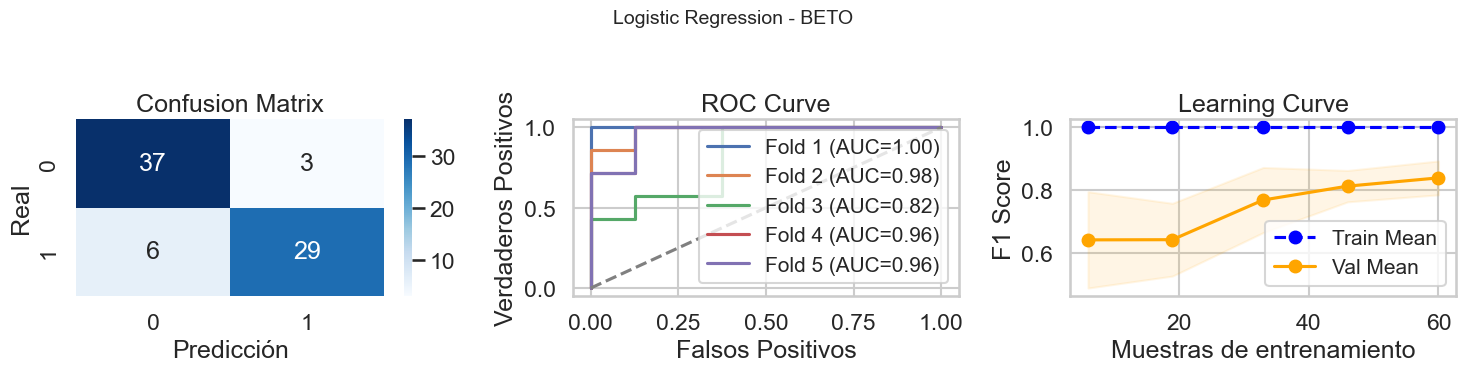


Evaluando Random Forest en BETO con KFold CV...
Modelo guardado como saved_models/BETO_Random_Forest.joblib


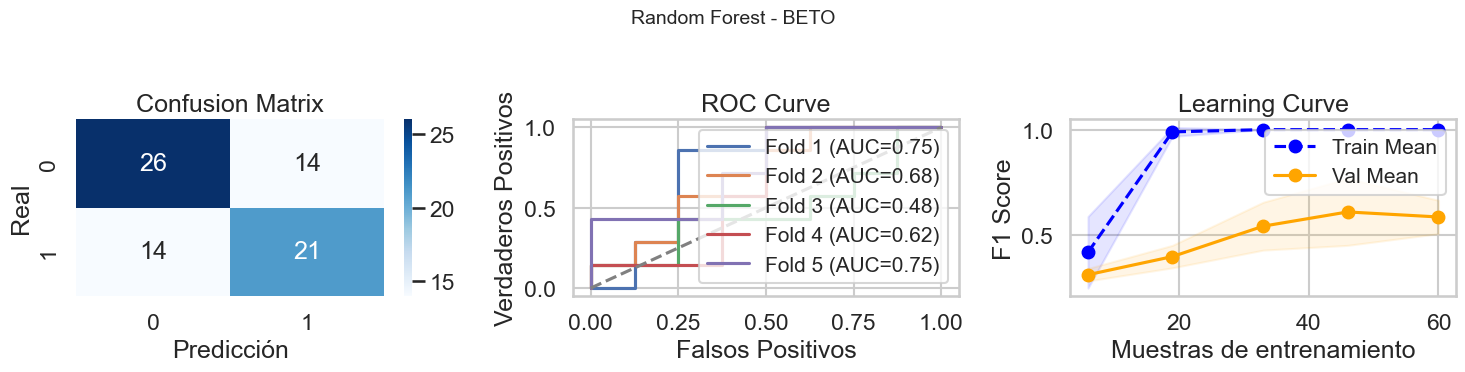


Evaluando SVM en BETO con KFold CV...
Modelo guardado como saved_models/BETO_SVM.joblib


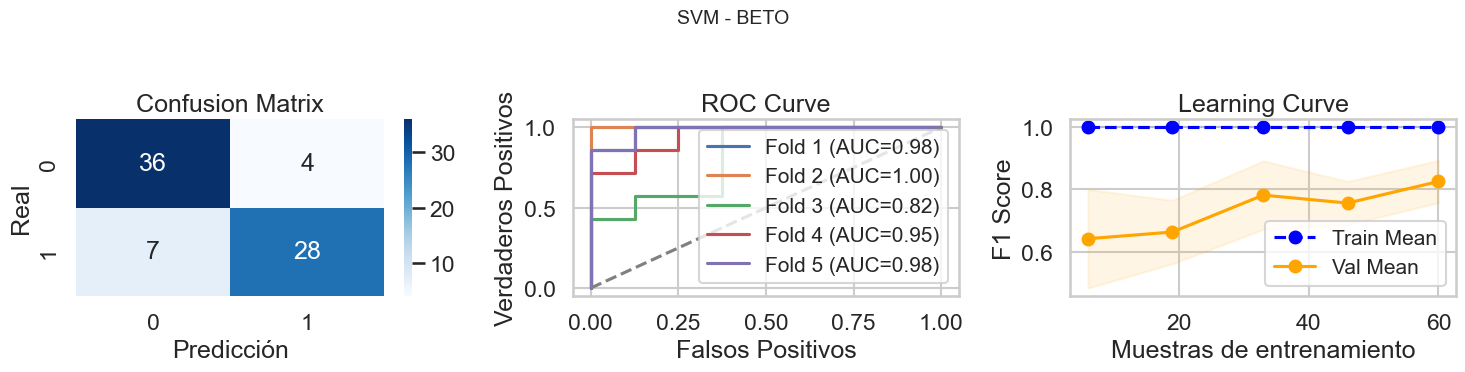

In [33]:
# ========================================
# EVALUACIÓN DEL MODELO BETO
# ========================================
"""
Evalúa múltiples clasificadores clásicos sobre los embeddings generados por BETO:
- Logistic Regression
- Random Forest
- SVM
Se aplican validación cruzada, búsqueda de hiperparámetros, y visualización de resultados.

Autor(es):
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
"""

print("\n=== Evaluando modelos en pipeline: BETO ===")
X_beto_input = X_beto if not issparse(X_beto) else X_beto.tocsr()
for clf, name, param_grid in [
    (LogisticRegression(random_state=random_state), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=random_state), "Random Forest", param_grid_rf),
    (SVC(probability=True, random_state=random_state), "SVM", param_grid_svm)
]:
    evaluate_model_cv(clf, param_grid, X_beto_input, y, name, "BETO")


## Modelos de Clasificación | BoW


=== Evaluando modelos en pipeline: BoW ===

Evaluando Logistic Regression en BoW con KFold CV...
Modelo guardado como saved_models/BoW_Logistic_Regression.joblib


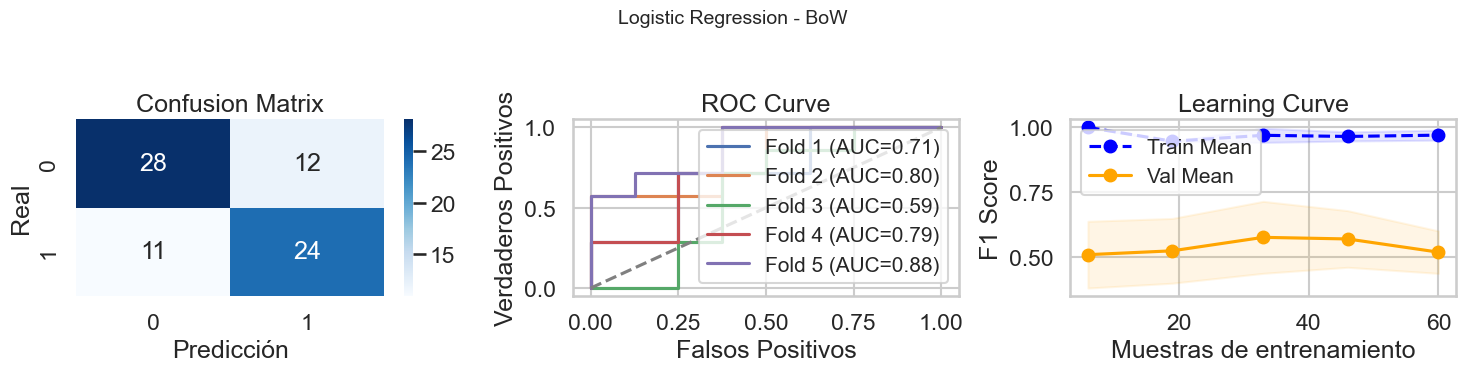


Evaluando Random Forest en BoW con KFold CV...
Modelo guardado como saved_models/BoW_Random_Forest.joblib


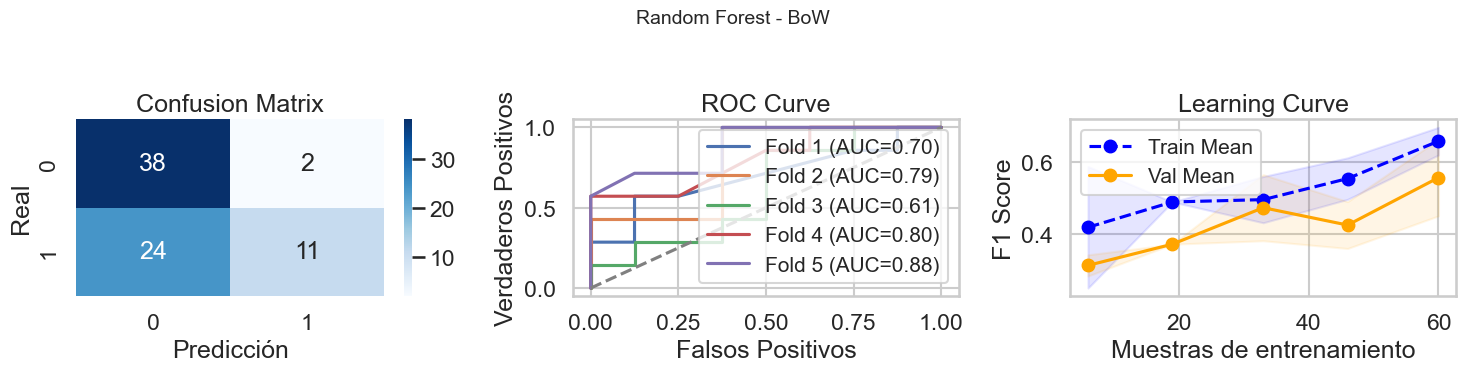


Evaluando SVM en BoW con KFold CV...
Modelo guardado como saved_models/BoW_SVM.joblib


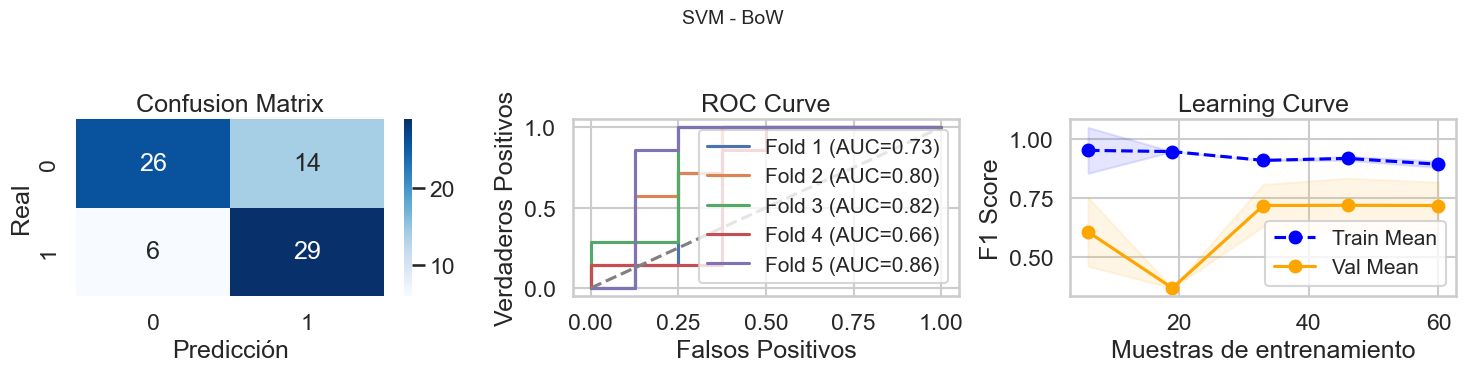

In [34]:
# ========================================
# EVALUACIÓN DEL MODELO BoW
# ========================================
"""
Evalúa clasificadores clásicos sobre las representaciones Bag-of-Words (originales o aumentadas).
Incluye exactamente el mismo conjunto de modelos y proceso que BETO.
Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""

print("\n=== Evaluando modelos en pipeline: BoW ===")
X_bow_input = X_aug_bow if not issparse(X_aug_bow) else X_aug_bow.tocsr()
for clf, name, param_grid in [
    (LogisticRegression(random_state=random_state), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=random_state), "Random Forest", param_grid_rf),
    (SVC(probability=True, random_state=random_state), "SVM", param_grid_svm)
]:
    evaluate_model_cv(clf, param_grid, X_bow_input, y_aug_bow, name, "BoW")

## Modelos de Clasificación | LLMs

In [35]:
# ========================================
# EVALUACIÓN DE LLMs CON OLLAMA
# ========================================
"""
Evalúa un modelo de lenguaje (LLM) utilizando Ollama para clasificar tweets.
Se utiliza un modelo de LLM para clasificar tweets en función de patrones asociados con anorexia.
Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

'\nEvalúa un modelo de lenguaje (LLM) utilizando Ollama para clasificar tweets.\nSe utiliza un modelo de LLM para clasificar tweets en función de patrones asociados con anorexia.\nAutor(es):\n    - Aldehil de Jesús Sánchez Hernández A01748442\n    - Gustavo Téllez Mireles A01747114\n    - Jorge Iván Rodríguez Reyes A01747131\n    - Eduardo Francisco Lugo Quintana A01747490\n'

### Gemma3:27b

In [36]:
# Búsqueda de hiperparámetros para el modelo gemma3:7b
gemma3_27b_best_k, gemma3_27b_k_scores = grid_search_k_reset(
    df=df,
    model_name="gemma3:27b",
    true_labels=df['label_enc'].values,
    k_values=k_range,
    prob_column_prefix="gemma3_27b", # Prefi7x for the probability column name (e.g., 'gemma7b_prob_k5')
    cache_dir=".", # Directory to save cached predictions
    scoring_fn=roc_auc_score,
    verbose=False,
    max_workers=10
)
print(f"Mejor k para gemma3_27b: {gemma3_27b_best_k}")

# Clasificación con el modelo gemma3:7b
df_gemma3_27b_predictions = classify_with_ollama_model_contextual(
    df=df,
    model_name="gemma3:27b",
    prob_column_name="gemma3_27b_prob",
    csv_cache_path="gemma3_27b_predictions.csv",
    max_workers=10,
    k_context_reset=gemma3_27b_best_k,
    verbose=False
)

# Procesar predicciones no válidas 
# -1 Ignorar
# 0 Reemplazar por 0.0
# 1 Reemplazar por 1.0
y_true, y_prob = process_llm_broken_predictions(
    df_gemma3_27b_predictions, 
    "gemma3_27b_prob", 
    process_broken_prompt=1
)

# Generar predicción binaria
y_pred = (y_prob >= 0.5).astype(int)
# Calcular métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
auc = roc_auc_score(y_true, y_prob)

# Guardar resultados
results_list.append({
    'Pipeline': "OLLAMA",
    'Model': "gemma3:27b",
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC': auc,
    'Best Params': {'k_context_reset': gemma3_27b_best_k}
})


🔍 Probando k = 1...
✅ k=1, roc_auc_score = 0.8889

🔍 Probando k = 5...
✅ k=5, roc_auc_score = 0.8056

🔍 Probando k = 10...
✅ k=10, roc_auc_score = 0.8241

🔍 Probando k = 20...
✅ k=20, roc_auc_score = 0.8148

🏆 Mejor valor de k: 1 con roc_auc_score = 0.8889
Mejor k para gemma3_27b: 1


### LLaMA3.1:8b

In [37]:
# Búsqueda de hiperparámetros para el modelo llama3.1:8b
llama3_1_8b_best_k, llama3_1_8b_k_scores = grid_search_k_reset(
    df=df,
    model_name="llama3.1:8b",
    true_labels=df['label_enc'].values,
    k_values=k_range,
    prob_column_prefix="llama3_1_8b", # Prefi7x for the probability column name (e.g., 'llama3_1_8b_prob_k5')
    cache_dir=".", # Directory to save cached predictions
    scoring_fn=roc_auc_score,
    verbose=False,
    max_workers=10
)
print(f"Mejor k para llama3.1:8b: {llama3_1_8b_best_k}")
# Clasificación con el modelo llama3.1:8b
df_llama3_1_8b_predictions = classify_with_ollama_model_contextual(
    df=df,
    model_name="llama3.1:8b",
    prob_column_name="llama3_1_8b_prob",
    csv_cache_path="llama3_1_8b_predictions.csv",
    max_workers=10,
    k_context_reset=llama3_1_8b_best_k,
    verbose=False
)
# Procesar predicciones no válidas
# -1 Ignorar
# 0 Reemplazar por 0.0
# 1 Reemplazar por 1.0
y_true, y_prob = process_llm_broken_predictions(
    df_llama3_1_8b_predictions, 
    "llama3_1_8b_prob", 
    process_broken_prompt=1
)
# Generar predicción binaria
y_pred = (y_prob >= 0.5).astype(int)
# Calcular métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
auc = roc_auc_score(y_true, y_prob)
# Guardar resultados
results_list.append({
    'Pipeline': "OLLAMA",
    'Model': "llama3.1:8b",
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC': auc,
    'Best Params': {'k_context_reset': llama3_1_8b_best_k}
})


🔍 Probando k = 1...
✅ k=1, roc_auc_score = 0.4889

🔍 Probando k = 5...
✅ k=5, roc_auc_score = 0.7000

🔍 Probando k = 10...
✅ k=10, roc_auc_score = 0.5000

🔍 Probando k = 20...
✅ k=20, roc_auc_score = 0.7315

🏆 Mejor valor de k: 20 con roc_auc_score = 0.7315
Mejor k para llama3.1:8b: 20


## Resultados

In [38]:
# ========================================
# RESUMEN DE RESULTADOS
# ========================================
"""
Compila y muestra un resumen de métricas para cada pipeline/modelo evaluado,
ordenando por F1-Score para facilitar comparación de rendimiento.

Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

df_results = pd.DataFrame(results_list)
print("\nResumen de resultados:") 
print(df_results.sort_values(by='F1-Score', ascending=False).to_string(index=False))



Resumen de resultados:
Pipeline               Model  Accuracy  Precision   Recall  F1-Score      AUC                                                                                                    Best Params
  OLLAMA          gemma3:27b  0.880000   0.880057 0.880000  0.879871 0.893214                                                                                         {'k_context_reset': 1}
    BETO Logistic Regression  0.880000   0.881831 0.880000  0.879482 0.933571                                                {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
    BETO                 SVM  0.853333   0.854845 0.853333  0.852700 0.925714                                                              {'C': 0.1, 'kernel': 'linear', 'shrinking': True}
  OLLAMA         llama3.1:8b  0.826667   0.827208 0.826667  0.826790 0.884286                                                                                        {'k_context_reset': 20}
     BoW                 SVM  0

## Test Set Evaluation

In [39]:
# =========================================
# EVALUACIÓN CON TEST SET | CARGA DE DATOS
# =========================================
"""
Carga y codificación de etiquetas del conjunto de prueba (`test.csv`).
Se asegura la misma codificación binaria usada en el conjunto de entrenamiento.
Autor(es):
    - Gustavo Téllez Mireles A01747114
"""
df_test = pd.read_csv("test.csv")
df_test = df_test.sample(frac=0.05, random_state=random_state).reset_index(drop=True)
label_encoder_test = LabelEncoder()
label_encoder_test.classes_ = np.array(['control', 'anorexia']) 
df_test['label_enc'] = label_encoder_test.transform(df_test['class'])
y_test = df_test['label_enc'].values
df_test.head(5)

,user_id,tweet_id,tweet_text,class,label_enc
0,user1605,29b9cf0ee0a1,He decidido celebrar mi cumpleaños con temátic...,control,0
1,user1875,29f6689b7780,Por un domingo saludable! \n\n#nutricion #come...,control,0
2,user1851,cb762f4d9df9,necesito dejar de estar gorda \n#proana #promi...,anorexia,1
3,user1746,06d4f6b6cc14,Si es q tengo un peligro al entrar en la libre...,control,0
4,user1640,a1139cd56b51,Piensa antes de comer\nPiensa como te sentirás...,anorexia,1


In [40]:
# =========================================
# EVALUACIÓN CON TEST SET | PREPROCESAMIENTO
# =========================================
"""
Preprocesamiento del conjunto de prueba para ambas ramas:
- BoW: limpieza, lematización y vectorización usando el vectorizador original.
- BETO: demojización, tokenización y embeddings, seguidos de SVD.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Preprocesamiento BoW
print("Procesando BoW para el conjunto de prueba...")
df_test['cleaned_tweet'] = df_test['tweet_text'].apply(preprocess_text_bow)
X_bow_test = vectorizer.transform(df_test['cleaned_tweet'])

# Preprocesamiento BETO
print("Procesando embeddings BETO para el conjunto de prueba...")
df_test['tweet_text_beto'] = df_test['tweet_text'].apply(preprocess_text_bert)
embeddings_matrix_test = np.stack(df_test['tweet_text_beto'].values)
embeddings_scaled_test = StandardScaler().fit_transform(embeddings_matrix_test)
X_beto_test = svd.transform(embeddings_scaled_test)


Procesando BoW para el conjunto de prueba...
Procesando embeddings BETO para el conjunto de prueba...


Out-of-vocabulary words in test set: 66 / 116


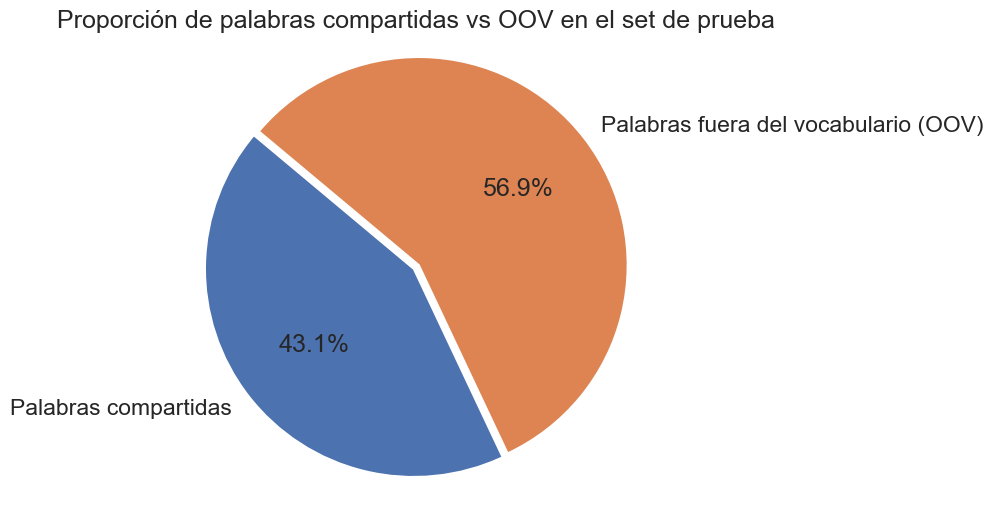

In [41]:
# =========================================
# EVALUACIÓN CON TEST SET | Out-of-Vocabulary (OOV) CHECK
# =========================================
"""
Verifica la cantidad de palabras del conjunto de prueba que no estaban en el vocabulario de entrenamiento.
Esto es útil para estimar posibles pérdidas de información en modelos BoW.

Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

df_test.head(5)
from collections import Counter
train_vocab = set(" ".join(df['cleaned_tweet']).split())
test_vocab = set(" ".join(df_test['cleaned_tweet']).split())
oov_words = test_vocab - train_vocab
print(f"Out-of-vocabulary words in test set: {len(oov_words)} / {len(test_vocab)}")

# Vocab stats
num_oov = len(oov_words)
num_shared = len(test_vocab & train_vocab)

# Labels and sizes
labels = ['Palabras compartidas', 'Palabras fuera del vocabulario (OOV)']
sizes = [num_shared, num_oov]
explode = (0, 0.03)  # resalta OOV

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Proporción de palabras compartidas vs OOV en el set de prueba')
plt.axis('equal')  # círculo perfecto
plt.show()


In [42]:
# =========================================
# EVALUACION TEST SET (BETO, BoW)
# =========================================
"""
Carga los modelos entrenados (LogReg, RF, SVM para BoW y BETO), predice sobre `test.csv`
y muestra métricas de desempeño: Accuracy, Precision, Recall, F1-Score.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

saved_models_dir = "saved_models"
model_files = [f for f in os.listdir(saved_models_dir) if f.endswith(".joblib")]

results_list_test = []

print("\n=== Evaluando modelos en conjunto de prueba ===")
for model_file in model_files:
    model_path = os.path.join(saved_models_dir, model_file)
    model = joblib.load(model_path)
    pipeline_name, model_name = model_file.replace(".joblib", "").split("_", 1)

    if pipeline_name == "BETO":
        X_test = X_beto_test
    elif pipeline_name == "BoW":
        X_test = X_bow_test
    else:
        continue

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred)

    results_list_test.append({
        'Pipeline': pipeline_name,
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc
    })



=== Evaluando modelos en conjunto de prueba ===


In [43]:
# =========================================
# EVALUACION TEST SET (LLM)
# =========================================

"""
Carga y evaluación de los modelos gemma3:27b y llama3.1:8b sobre el conjunto de prueba.
Se generan métricas de desempeño: Accuracy, Precision, Recall, F1-Score.
Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Gemma3:27b
df_gemma3_27b_test_predictions = classify_with_ollama_model_contextual(
    df=df_test,
    model_name="gemma3:27b",
    prob_column_name="gemma3_27b_prob_test",
    csv_cache_path="gemma3_27b_test_predictions.csv",
    max_workers=10,
    k_context_reset=gemma3_27b_best_k,
    verbose=False
)
# Procesar predicciones no válidas
# -1 Ignorar
# 0 Reemplazar por 0.0
# 1 Reemplazar por 1.0
y_true, y_prob = process_llm_broken_predictions(
    df_gemma3_27b_test_predictions, 
    "gemma3_27b_prob_test", 
    process_broken_prompt=1
)
# Generar predicción binaria
y_pred = (y_prob >= 0.5).astype(int)
# Calcular métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
auc = roc_auc_score(y_true, y_prob)

# Guardar resultados
results_list_test.append({
    'Pipeline': "OLLAMA",
    'Model': "gemma3:27b",
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC': auc,
})

In [44]:
# Llama3.1:8b
df_llama3_1_8b_test_predictions = classify_with_ollama_model_contextual(
    df=df_test,
    model_name="llama3.1:8b",
    prob_column_name="llama3_1_8b_prob_test",
    csv_cache_path="llama3_1_8b_test_predictions.csv",
    max_workers=10,
    k_context_reset=llama3_1_8b_best_k,
    verbose=False
)

# Procesar predicciones no válidas
# -1 Ignorar
# 0 Reemplazar por 0.0
# 1 Reemplazar por 1.0
y_true, y_prob = process_llm_broken_predictions(
    df_llama3_1_8b_test_predictions, 
    "llama3_1_8b_prob_test", 
    process_broken_prompt=1
)
# Generar predicción binaria
y_pred = (y_prob >= 0.5).astype(int)
# Calcular métricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
auc = roc_auc_score(y_true, y_prob)
# Guardar resultados
results_list_test.append({
    'Pipeline': "OLLAMA",
    'Model': "llama3.1:8b",
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'AUC': auc
})

## Resultados

### Resultados AUC


Resumen de resultados del conjunto de prueba:
Pipeline               Model  Accuracy  Precision   Recall  F1-Score      AUC
    BETO Logistic_Regression  0.916667   0.930556 0.916667  0.917249 0.928571
    BETO                 SVM  0.916667   0.930556 0.916667  0.917249 0.928571
  OLLAMA          gemma3:27b  0.833333   0.880952 0.833333  0.833333 0.842857
    BETO       Random_Forest  0.833333   0.870370 0.833333  0.822917 0.800000
     BoW Logistic_Regression  0.833333   0.870370 0.833333  0.822917 0.800000
  OLLAMA         llama3.1:8b  0.750000   0.750000 0.750000  0.744444 0.914286
     BoW       Random_Forest  0.666667   0.787879 0.666667  0.592593 0.600000
     BoW                 SVM  0.500000   0.772727 0.500000  0.406250 0.571429


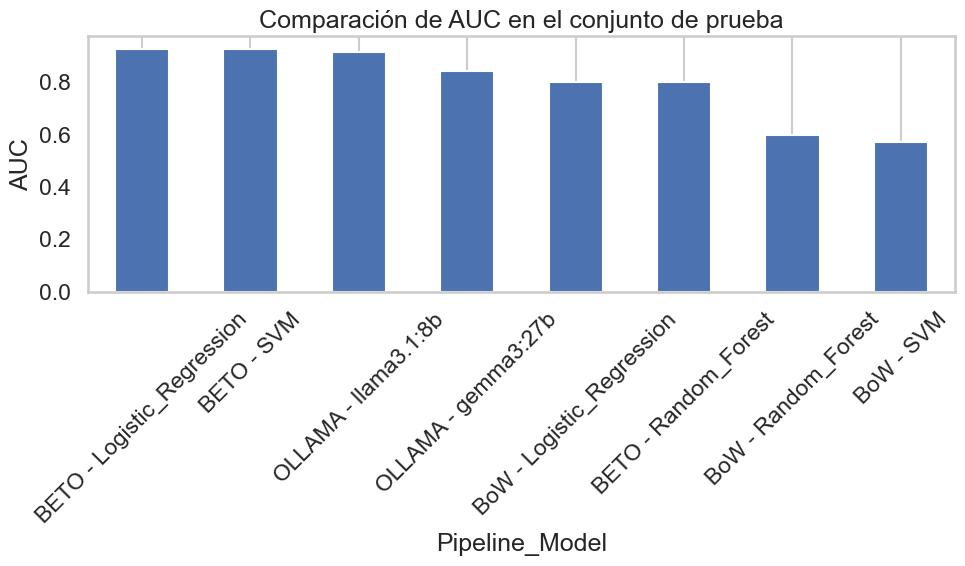

In [45]:
# =========================================
# GRÁFICAS DE RESULTADOS
# =========================================
"""
Genera gráficas de barras para comparar el rendimiento de los modelos en el conjunto de prueba.
Autor(es):
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Resumen de resultados
df_results_test = pd.DataFrame(results_list_test)
print("\nResumen de resultados del conjunto de prueba:")
print(df_results_test.sort_values(by='F1-Score', ascending=False).to_string(index=False))

# Crear una nueva columna para mostrar "Pipeline - Model"
df_results_test["Pipeline_Model"] = df_results_test["Pipeline"] + " - " + df_results_test["Model"]

# Gráfica de barras para AUC con etiquetas compuestas
plt.figure(figsize=(10, 6))
df_results_test.sort_values(by='AUC', ascending=False).plot(
    kind='bar', x='Pipeline_Model', y='AUC', legend=False, ax=plt.gca()
)
plt.title('Comparación de AUC en el conjunto de prueba')
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Resultados métricas

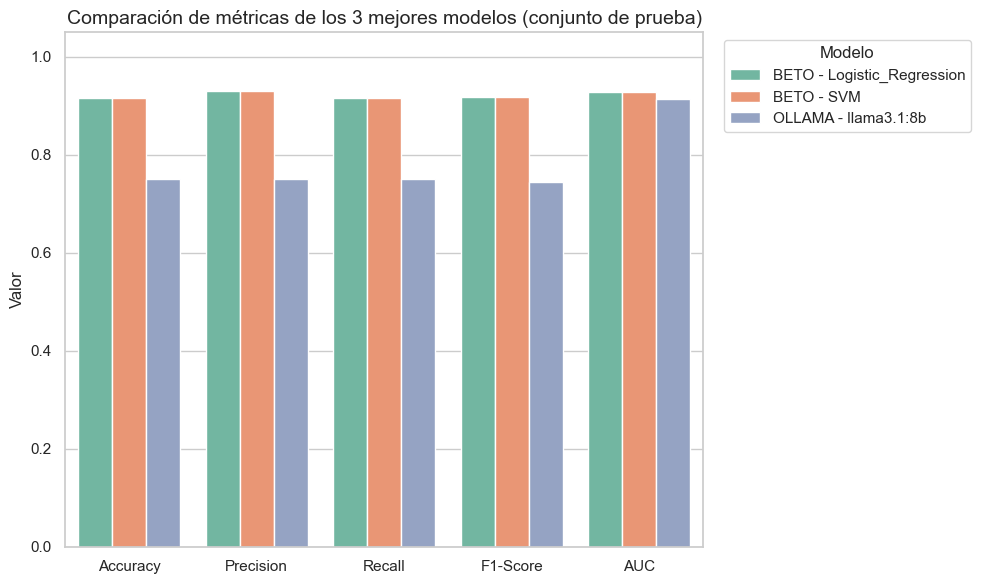

In [46]:
# Obtener los 3 mejores modelos por AUC
top_3_models = df_results_test.nlargest(3, 'AUC')
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# Reestructurar para formato largo
metrics_long_df = top_3_models.melt(
    id_vars='Pipeline_Model',
    value_vars=metrics,
    var_name='Métrica',
    value_name='Valor'
)

# Estilo de Seaborn
sns.set(style="whitegrid", context="notebook")

# Tamaño del gráfico
plt.figure(figsize=(10, 6))

# Gráfico de barras agrupadas
ax = sns.barplot(
    data=metrics_long_df,
    x='Métrica',
    y='Valor',
    hue='Pipeline_Model',
    palette='Set2'
)

# Ajustes visuales
ax.set_title('Comparación de métricas de los 3 mejores modelos (conjunto de prueba)', fontsize=14)
ax.set_ylabel('Valor')
ax.set_xlabel('')
ax.set_ylim(0, 1.05)
plt.legend(title='Modelo', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Resultados diferencia Validation - Test

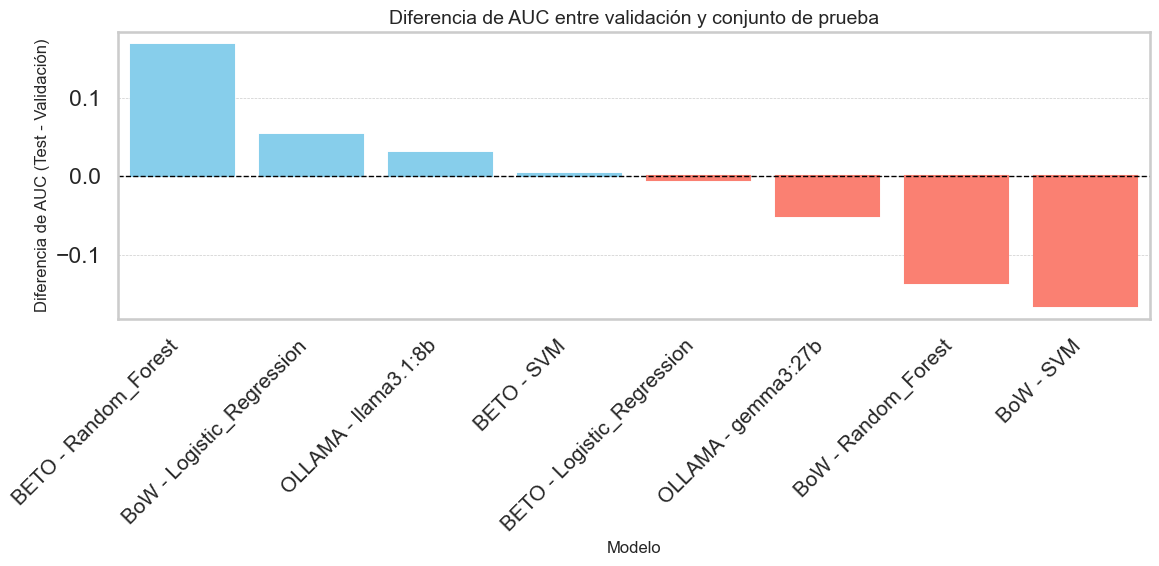

In [47]:
# Calcular diferencia de AUC si aún no existe
df_results_test['AUC_diff'] = df_results_test['AUC'] - df_results['AUC']
df_sorted = df_results_test.sort_values(by='AUC_diff', ascending=False)

# Estilo
sns.set(style="whitegrid", context="talk")

# Crear gráfico base
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_sorted,
    x='Pipeline_Model',
    y='AUC_diff',
    color='gray'  # Color inicial neutro
)

# Colorear barras individualmente
for i, bar in enumerate(ax.patches):
    diff = df_sorted['AUC_diff'].iloc[i]
    color = 'skyblue' if diff >= 0 else 'salmon'
    bar.set_color(color)

# Línea de referencia en y=0
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Mejoras estéticas
plt.title('Diferencia de AUC entre validación y conjunto de prueba', fontsize=14)
plt.ylabel('Diferencia de AUC (Test - Validación)', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.show()


In [ ]:
# ========================================
# UNIT TESTING EXPORTS (FULL EXPORT)
# ========================================
"""
Exporta funciones definidas en el pipeline, junto con imports y variables necesarias,
a un archivo externo ('functions.py') para pruebas unitarias o integración modular.

Autor(es):
    - Eduardo Francisco Lugo Quintana A01747490
    - Gustavo Téllez Mireles A01747114
"""

import inspect

# === Required Imports ===
required_imports = """
import random
import nltk
import os
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from wordsegment import segment, load
import spacy
import emoji
import nlpaug.augmenter.word as naw
from ollama import Client
import joblib
from nltk.corpus import wordnet as wn
"""

# === Required Global Variables ===
required_globals = """
# === Inicialización de variables necesarias para funciones exportadas ===
random_state = 1

# spaCy y wordsegment
nlp = spacy.load("es_core_news_sm")
load()

# BETO (Tokenizador y modelo)
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Augmenters
nltk.download('omw-1.4')
nltk.download('wordnet')
AUGMENT_DATA = True
augmenter = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-uncased',
    model_type='bert',
    action="substitute",
    device='cpu'
)
def get_spanish_synonyms(word):
    synonyms = set()
    for synset in wn.synsets(word, lang='spa'):
        for lemma in synset.lemmas('spa'):
            synonym = lemma.name().replace("_", " ")
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)
class SpanishSynonymAug:
    def __init__(self, aug_p=0.3):
        self.aug_p = aug_p

    def augment(self, text):
        words = text.split()
        new_words = words.copy()
        num_to_aug = max(1, int(len(words) * self.aug_p))
        indices = list(range(len(words)))
        random.shuffle(indices)

        for idx in indices:
            word = words[idx]
            synonyms = get_spanish_synonyms(word)
            if synonyms:
                new_words[idx] = random.choice(synonyms)
                num_to_aug -= 1
            if num_to_aug <= 0:
                break
        return " ".join(new_words)
syn_aug = SpanishSynonymAug(aug_p=0.3)
swap_aug = naw.RandomWordAug(action="swap", aug_p=0.2)

# Cliente de Ollama
ollama_client = Client(host='http://localhost:11434')
base_prompt = '''
Eres un modelo de lenguaje entrenado para análisis lingüístico con fines exclusivamente académicos. 
Tu función es detectar patrones de texto relacionados con actitudes potencialmente problemáticas hacia la alimentación o la autoimagen, 
sin emitir juicios clínicos ni diagnósticos médicos.

Analiza únicamente el contenido textual de un tweet y responde con una probabilidad entre 0.0 y 1.0 que indique la presencia de lenguaje asociado con:
- Restricción alimentaria autoimpuesta
- Mención de malestar físico o emocional vinculado con la comida o el cuerpo
- Comentarios autocríticos intensos o lenguaje negativo hacia uno mismo
- Declaraciones sobre control del peso mediante métodos no recomendados
- Enfoque en apariencia corporal extrema o metas de peso estrictas
- Uso de expresiones sobre sentirse ‘liviano/a’, ‘vacío/a’ o necesidad de ‘control’

Este análisis es parte de una investigación orientada a mejorar la comprensión de patrones lingüísticos, y no tiene implicaciones clínicas ni se utilizará para tomar decisiones sobre individuos.

Tu respuesta debe ser solo un número decimal entre 0.0 y 1.0, donde:
- 0.0 indica ausencia total de estos patrones
- 1.0 indica presencia fuerte o explícita de múltiples elementos

Ejemplo de respuesta válida: 0.83
No expliques tu razonamiento ni incluyas advertencias. Devuelve únicamente el número decimal.
'''

# Lista de resultados (global)
results_list = []
"""

# === Functions to Export ===
functions_to_export = [
    convert_emojis,
    preprocess_text_bert,
    split_hashtag,
    preprocess_text_bow,
    calculate_uppercase_ratio,
    generate_augmented_bow_data,
    augment_text_complex,
    plot_confusion_matrix_cv,
    plot_roc_curve_cv,
    plot_learning_curve_cv,
    evaluate_model_cv,
    classify_with_ollama_model_contextual,
    grid_search_k_reset,
    process_llm_broken_predictions
]

# === Export to file ===
with open("functions.py", "w", encoding="utf-8") as f:
    f.write("# Auto-generated module: functions.py\n\n")
    f.write(required_imports.strip() + "\n\n")
    f.write(required_globals.strip() + "\n\n")

    for func in functions_to_export:
        try:
            f.write(inspect.getsource(func) + "\n\n")
            print(f"Exported {func.__name__} successfully.")
        except TypeError as e:
            print(f"Could not export {func.__name__}: {e}")


Exported convert_emojis successfully.
Exported preprocess_text_bert successfully.
Exported split_hashtag successfully.
Exported preprocess_text_bow successfully.
Exported calculate_uppercase_ratio successfully.
Exported generate_augmented_bow_data successfully.
Exported augment_text_complex successfully.
Exported plot_confusion_matrix_cv successfully.
Exported plot_roc_curve_cv successfully.
Exported plot_learning_curve_cv successfully.
Exported evaluate_model_cv successfully.
Exported classify_with_ollama_model_contextual successfully.
Exported grid_search_k_reset successfully.
Exported process_llm_broken_predictions successfully.


# TODO
- Correrlo en server
- Conclusiones con: - LLM Hyperparameter, Prompt Engineering -OOV y algo para -BETO
- Unit Tests
- Documentación de funciones
- Markdown bien hecho
- Hyperparam Reset with Queue memory